## Analyzing social networks to predict viral activity


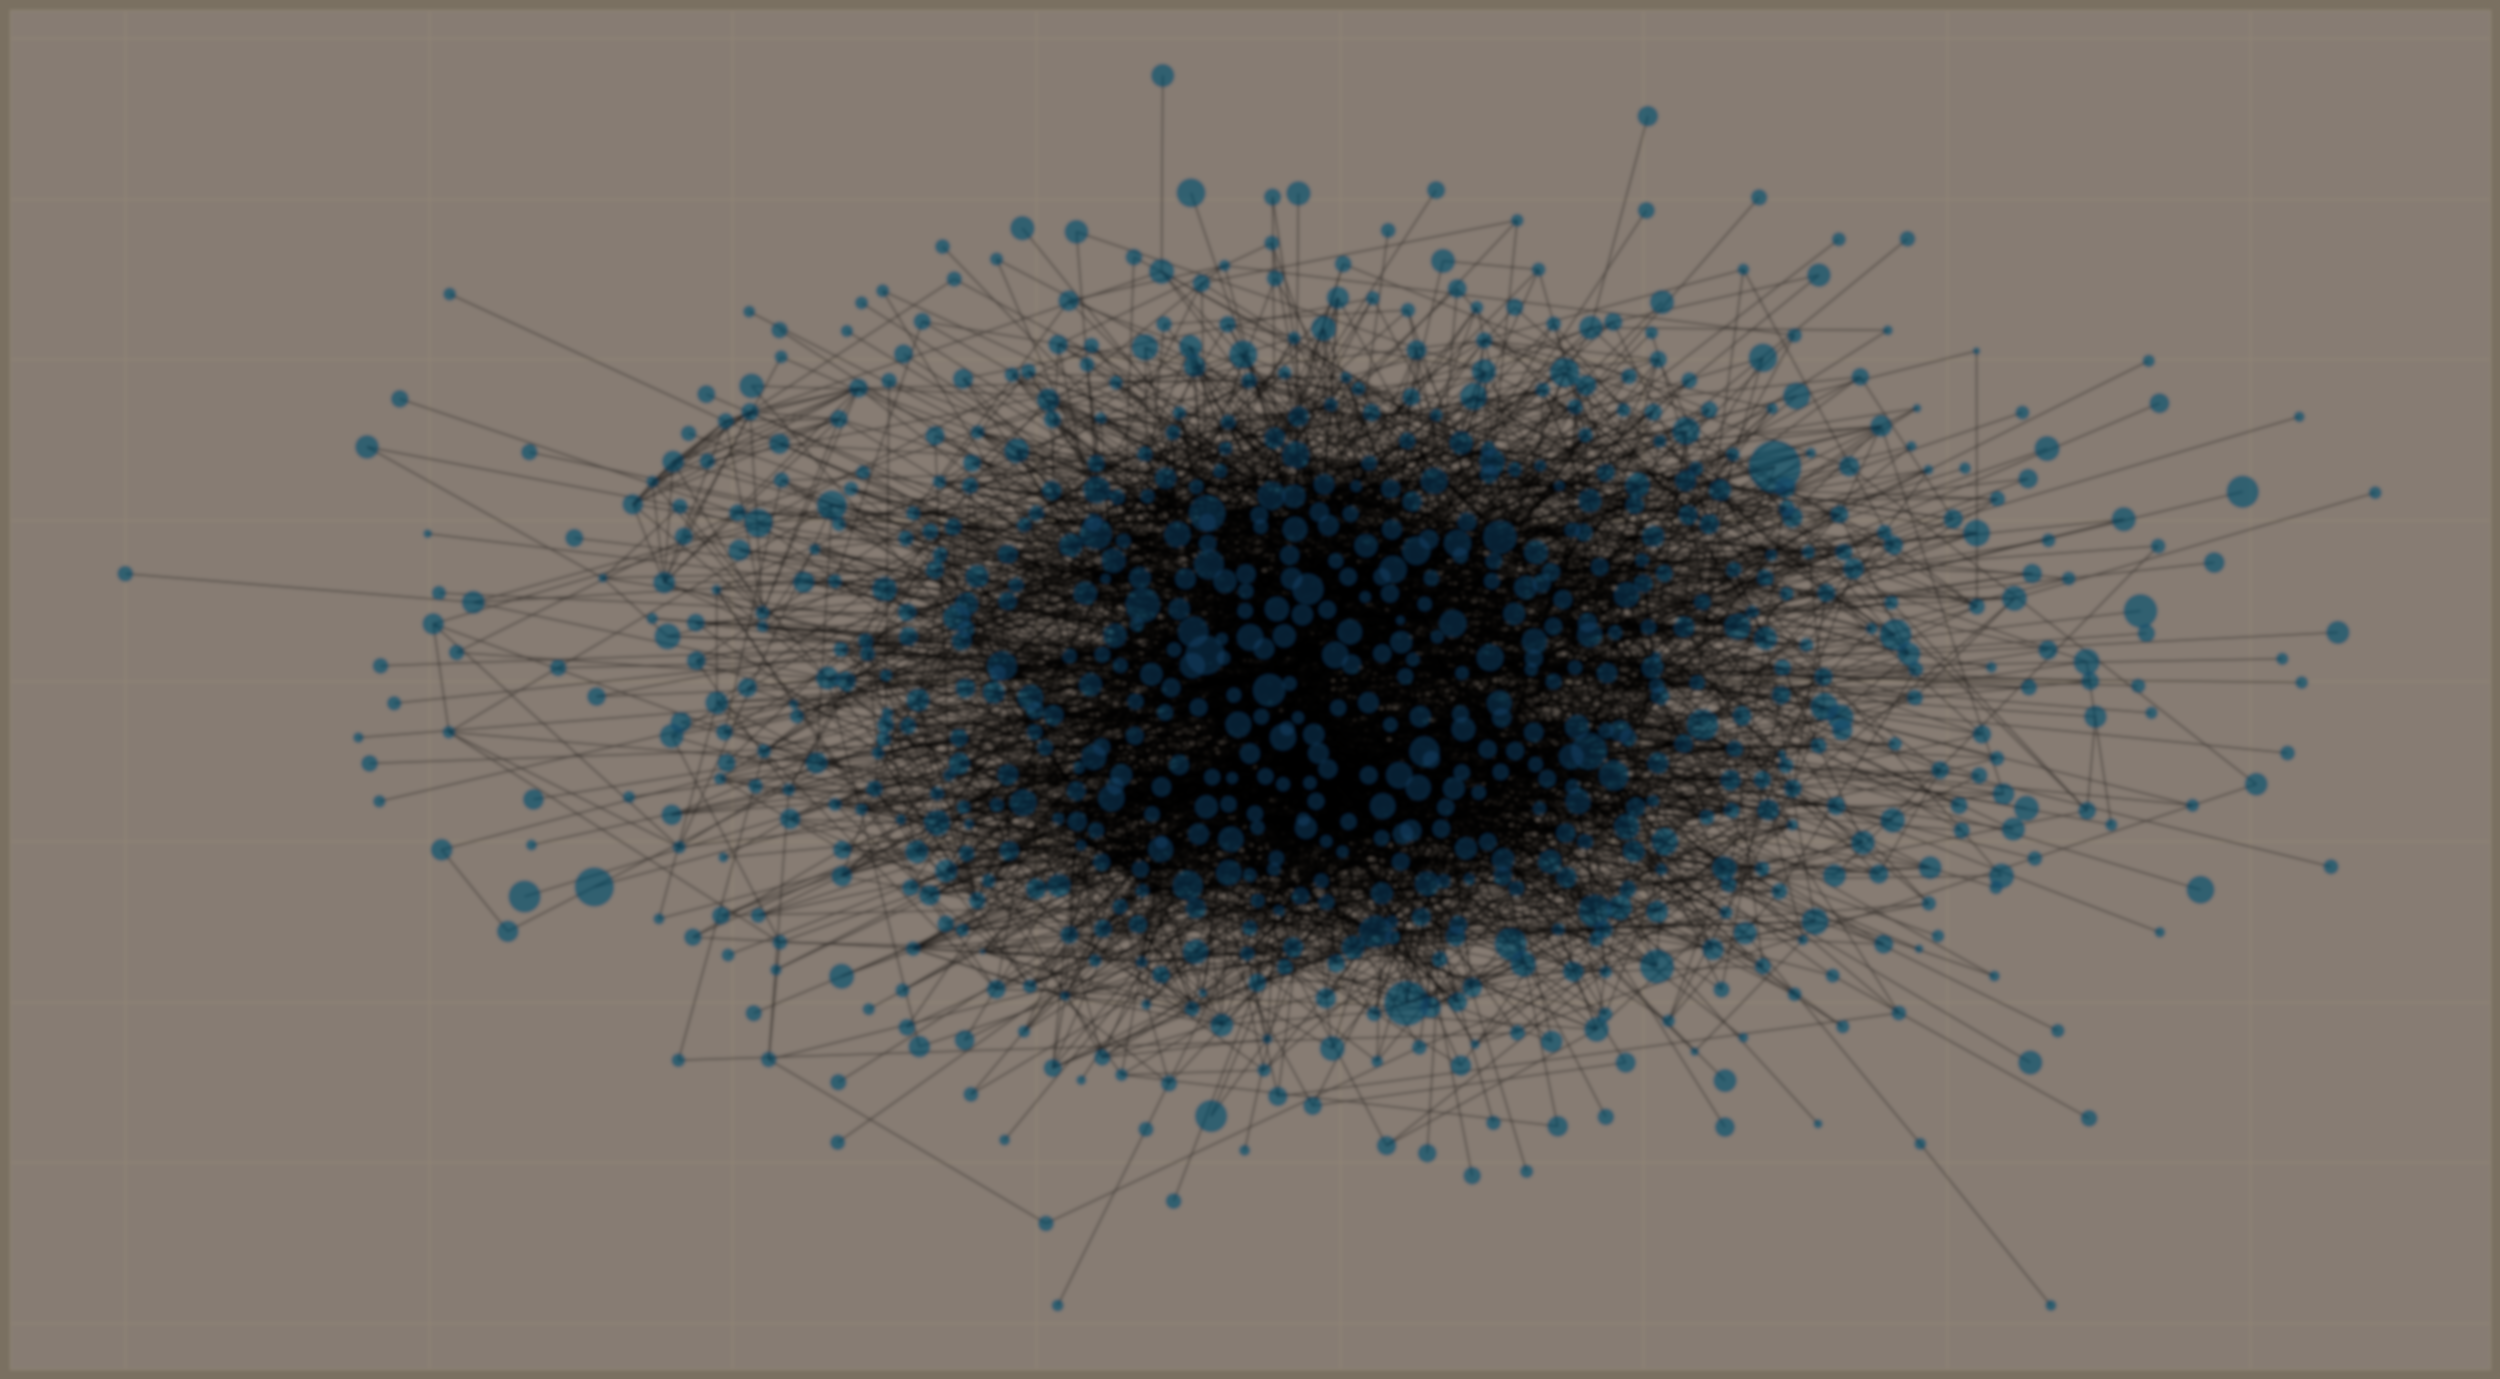

In [1]:
from IPython.display import Image
Image(filename='images/network.png')

##### Networks of airbnb listings connected by shared reviewers 

Given a collection of airbnb listings, and the reviewers who have reportedly stayed there, we can construct a graph where each listing is a node. Using the list of distinct ```reviewer_id```'s for each room, any two listings that share a reviewer between within a certain timeframe are then connected on the graph.   

In [2]:
import pandas as pd


# Load data from csv files, save listing.id column as listing_id 
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

print("Number of listings: {}\nNumber of reviews: {}".format(len(listings), len(reviews)))

Number of listings: 1180
Number of reviews: 60934


#### $\S1$: Data Preprocessing

- load 'listings.csv' and 'reviews.csv' into pandas dataframes

- reformat ```date``` into  ```year```, ```month```, and ```day``` columns

- merge ```listings``` with ```reviews``` on ```listing_id```

In [3]:
from datetime import datetime



""" Preprocess listings data """

# Rename id column for clarity
listings['listing_id'] = listings['id']


""" Preprocess reveiws data """

# Save datetime object to 'iso' 
iso = datetime.fromisoformat

# Load date attributes into relevant column
reviews['year'] = reviews.date.apply(lambda x: iso(x).year)
reviews['month'] = reviews.date.apply(lambda x: iso(x).month)
reviews['day'] = reviews.date.apply(lambda x: iso(x).day)


""" Merge dataframes """

# Select necessary columns from each dataframe and merge
list_cols = ['listing_id','id']
rev_cols = ['listing_id', 'reviewer_id', 'year', 'month', 'day']

# Save merged data to new dataframe
df = listings[list_cols].merge(reviews[rev_cols], on='listing_id' , how='inner').dropna() 


""" Display results """

# Set display options and print results
pd.set_option('display.max_colwidth',40)
pd.set_option('display.max_rows',6)

df.head(-1)


,listing_id,id,reviewer_id,year,month,day
0,8521,8521,25629,2009,7,23
1,8521,8521,26357,2009,7,30
2,8521,8521,5747319,2013,8,30
...,...,...,...,...,...,...
60930,42037691,42037691,129493458,2020,2,28
60931,42270014,42270014,306674516,2020,2,14
60932,42509402,42509402,48441856,2020,3,1


#### $\S2$  Data Aggregation
- Select ```YEAR``` to restrict our analysis to
- Get array of all combinations of ```['listing_id','reviewer_id']```
- Create ```reviewer_dictionary``` where ```listing_id:['reviewer1',reviewer2', ... ]```
- Get list of all possible combinations; ```[('listing_i', 'listing_j'), ...]```

In [4]:
from itertools import combinations
import numpy as np



# Isolate year we want to restrict our listings to
YEAR = 2020

# Get the set of all listings and their reviewers, and a set of unique listings
data = np.array(df[df.year==YEAR][['listing_id', 'reviewer_id']])
unique_listings = np.unique(data[:,0])

# Create dictionary of reviewers for each listing
reviewer_dict = {i:np.unique([row[-1] for row in data if row[0]==i]) for i in unique_listings}

# Get list of all possible combinations of listings
all_combinations = [comb for comb in combinations(unique_listings,2)]


#### $\S3$ Data Selection

Using the list of all combinations created above, if we restrict our list to 

```(listing_i,listing_j)``` such that ```reviewer_dict[listing_i]``` $\cap$ ```reviewer_dict[listing_j]``` $\neq\varnothing$ 

then we are left with a list edges to connect the nodes on our graph. 

(The next cell may take long to run depending on the size of your data)

In [5]:
def isin(combo,dic):
    """ Returns number of shared reviewers bewteen two listings """
    revs1 = dic[combo[0]]
    revs2 = dic[combo[1]]
    return sum(np.isin(revs1,revs2))

def get_edges(combs,dic):
    """ Returns a list of tuples containing connected listings"""
    edges = []
    edges.extend(filter(lambda x: isin(x,dic), combs)) 
    return edges

# Get edges for graph
edges = get_edges(all_combinations, reviewer_dict)


From experience, a majority of listings share no reviewers with others and they can obscure information present in the graph.

Instead of graphing every listing, restrict the set of nodes to only those connected to other nodes

In [6]:
# Restrict list of ids to those connected to others
connected_ids = []
for edge in edges:
    connected_ids += edge

#### $\S4$ Graph Analysis

Finally, lets examine the connectivity of airbnb listings, shared by patrons in 2020

In [7]:
import matplotlib.pyplot as plt

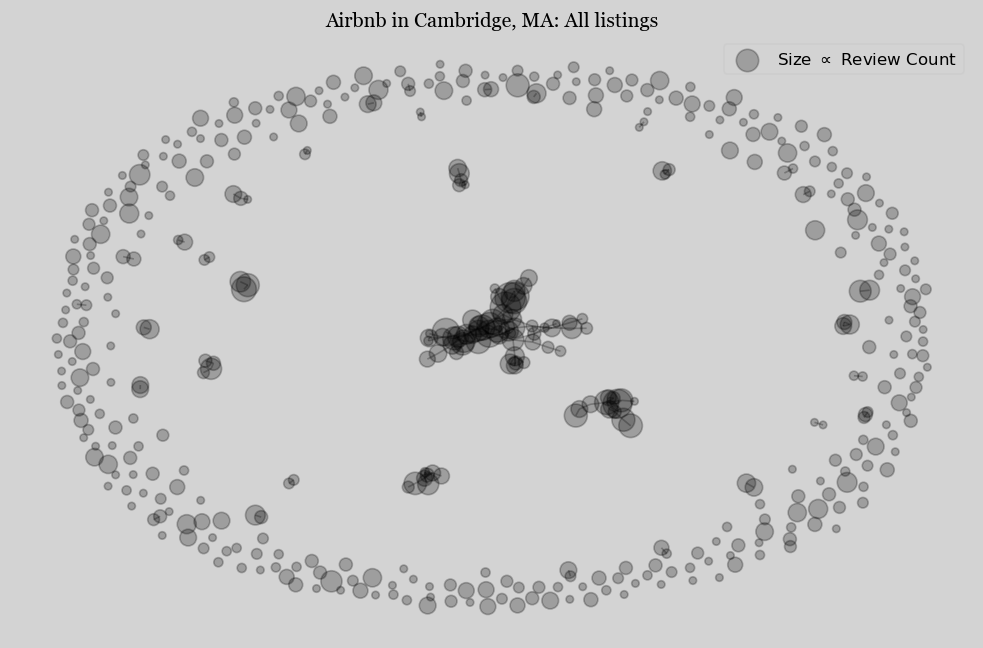

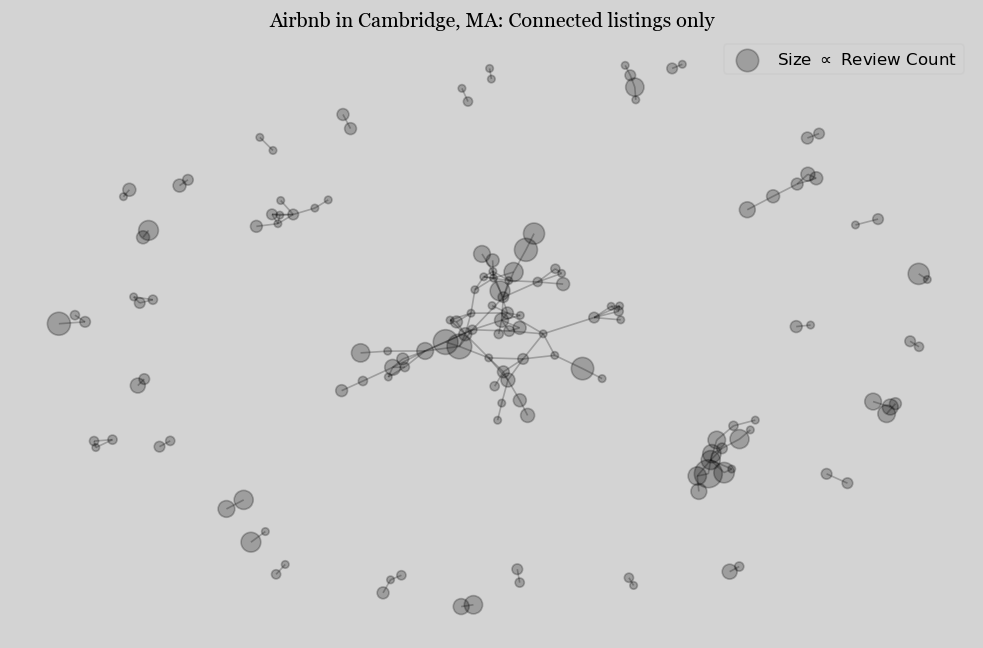

In [9]:
import networkx as nx



# List of titles
titles = ["All listings", "Connected listings only"]

# Draw Networkx graphs
for i,ids in enumerate([unique_listings, connected_ids]):
    
    # Add nodes and edges to our graph
    G = nx.Graph()
    G.add_nodes_from(ids)
    G.add_edges_from(edges)
    
    # Set figure size and pixel density
    fig = plt.figure(figsize=(8,5), dpi=120)
    
    # Set node size according to number of reviewers
    nsize = [10 * len(item[-1]) + 10 for item in reviewer_dict.items()]
                
    # Set network layout
    pos = nx.spring_layout(G)
    
    # Draw graph nodes
    nx.draw(G, pos, node_color='k', node_size=nsize, alpha=.25,with_labels=False)
    
    # Set figure color and title
    fig.set_facecolor("lightgrey")
    plt.title("Airbnb in Cambridge, MA: "+titles[i], fontname="Georgia")
    plt.grid() 
    plt.legend(["Size $\propto$ Review Count"], facecolor="lightgrey")
    plt.show() 

#### $\S5$ Concluding Remarks




For actual application to the spread of disease, this notebook leaves a few things to be desired, such as

- directionality: connecting each room based on if the reviewer stayed there after/before 
- weighting/distance: the edge between nodes should reflect length of time between stays


My intention is not to beat anyone to market here, I'm sure the bright folks in Palo Alto have much more sophisticated models under development. Just an instuctive example of graph analysis applied to social networks.

Thank you to Airbnb for the data provided here.

~SB